In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
#import plotly.plotly as py
import seaborn as sns
from sklearn import linear_model
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans, MeanShift
import statsmodels.tsa.stattools as tsa

%matplotlib inline

with pd.HDFStore("../train.h5", "r") as df:
    train = df.get("train")

train_a = train.dropna(axis=0)
train_f = train.fillna(train.mean())

In [1]:
train.head()

NameError: name 'train' is not defined

In [2]:
cols = [col for col in train_f.columns if col not in ['y','id','timestamp']]
cors = []
for col in cols:
    cors.append(np.corrcoef(train_f[col],train_f['y'])[0,1])
cors_sort = pd.DataFrame(abs(np.array(cors)), index=cols).sort(0, ascending=False)
cors_sort.head()

/Users/wenhaohu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,0
technical_20,0.016507
technical_30,0.014248
technical_27,0.008085
technical_19,0.007641
fundamental_11,0.007381


In [107]:
train['timestamp'].max()

1812

In [3]:
cols_to_use = ['fundamental_11', 'technical_19', 'technical_20', 'technical_30']
# cols_to_use = ['technical_20']
k = 0.75
cut = int(1812*k)
itrain = train['timestamp']<=cut
itest = ~itrain

In [298]:
y_high = train_f['y'].max()
y_low = train_f['y'].min()

In [299]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# kfold = KFold(train_f.shape[0], 10, shuffle=True)
rf = RandomForestRegressor(max_depth=3, random_state=0)
y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
rf.fit(train_f[cols_to_use][itrain][y_within], train_f['y'][itrain][y_within])
score = rf.score(train_f[cols_to_use][itest], train_f['y'][itest])
print('Random forest regressor score: {:.6f}'.format(score))

Random forest regressor score: 0.000254


In [300]:
rf.feature_importances_

array([ 0.06484024,  0.20027054,  0.57574052,  0.15914871])

In [126]:
dt = DecisionTreeRegressor(max_depth=3, random_state=0)
y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
dt.fit(train_f[cols_to_use][itrain][y_within], train_f['y'][itrain][y_within])
score = dt.score(train_f[cols_to_use][itest], train_f['y'][itest])
print('Decision tree regressor score: {:.6f}'.format(score))

Decision tree regressor score: -0.000192


In [288]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Outlier has not been removed
sc = StandardScaler()
X_train = sc.fit_transform(train_f[cols_to_use][itrain])
y_train = train_f['y'][itrain]
lr = LinearRegression()
# y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
lr.fit(X_train, y_train)
score = lr.score(sc.fit_transform(train_f[cols_to_use][itest]), train_f['y'][itest])
print('linear regressor score: {:.6f}'.format(score))

linear regressor score: 0.000382


In [289]:
# Outliers have been removed
y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
X_train = sc.fit_transform(train_f[cols_to_use][itrain][y_within])
y_train = train_f['y'][itrain][y_within]
lr.fit(X_train, y_train)
score = lr.score(sc.fit_transform(train_f[cols_to_use][itest]), train_f['y'][itest])
print('linear regressor score: {:.6f}'.format(score))

linear regressor score: 0.000342


In [290]:
def get_weighted_y(series):
    return 0.95*series + [0.05*y_median_dict[j] if j in y_median_dict
                                                       else series[i] for i,j in 
                                                  enumerate(train_f['id'][itest])]
class MyLinearRegressor(LinearRegression):
    def predict(self, X):
        temp = super(MyLinearRegressor,self).predict(X)
        return get_weighted_y(temp).clip(y_low, y_high)

In [293]:
# Adjusted linear regressor
mlr = MyLinearRegressor()
y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
train_data = train_f[itrain][y_within]
y_median_dict = dict(train_data.groupby('id')['y'].median())
mlr.fit(sc.fit_transform(train_data[cols_to_use]), train_data['y'])
score = mlr.score(sc.fit_transform(train_f[cols_to_use][itest]), train_f['y'][itest])
print('My linear regressor score: {:.6f}'.format(score))

My linear regressor score: 0.000351


In [151]:
from sklearn.linear_model import Ridge
class MyRidgeRegressor(Ridge):
    def predict(self, X):
        temp = super(MyRidgeRegressor,self).predict(X)
        return get_weighted_y(temp).clip(y_low, y_high)

In [152]:
# Adjusted ridge regressor
mrr = MyRidgeRegressor(alpha=0.3)
y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
train_data = train_f[itrain][y_within]
y_median_dict = dict(train_data.groupby('id')['y'].median())
mrr.fit(train_data[cols_to_use], train_data['y'])
score = mrr.score(train_f[cols_to_use][itest], train_f['y'][itest])
print('My Ridge regressor score: {:.6f}'.format(score))

My Ridge regressor score: 0.000359


In [4]:
import xgboost as xgb
from sklearn.metrics import r2_score
feat = ['fundamental_11', 'technical_19', 'technical_20', 'technical_30','technical_28']
X_train, y_train = train[feat][itrain], train['y'][itrain]
X_test, y_test = train[feat][itest], train['y'][itest]
dtrain = xgb.DMatrix(X_train, label = y_train.values)
param = {'booster':           'gbtree',
         'objective':         'reg:linear',
         'learning_rate':     0.025,
         'max_depth':         2,
         'subsample':         0.5,
         'colsample_bytree':  0.7,
         'colsample_bylevel': 0.7,
         'silent':            1
         }
print('train model...')
bst = xgb.train(params = param,
                dtrain = dtrain,
                num_boost_round = 500)
print('predicting...')
dtest = xgb.DMatrix(X_test)
pred = bst.predict(dtest)
print("xgboost score is {:.6f}".format(r2_score(y_test, pred)))

train model...
predicting...
xgboost score is 0.000759


In [19]:
bst.save_model("models")

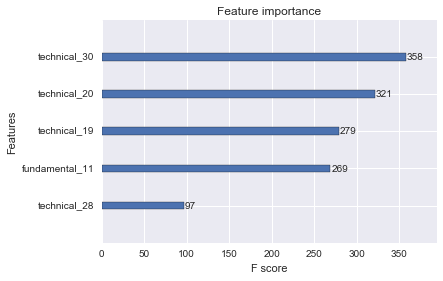

In [281]:
xgb.plot_importance(bst)

In [154]:
from sklearn.ensemble import RandomForestRegressor
class MyRandomForestRegressor(RandomForestRegressor):
    def predict(self, X):
        temp = super(MyRandomForestRegressor,self).predict(X)
        return get_weighted_y(temp).clip(y_low, y_high)

In [157]:
mrf = MyRandomForestRegressor(max_depth=3)
mrf.fit(train_f[cols_to_use][itrain], train_f['y'][itrain])
score = mrf.score(train_f[cols_to_use][itest], train_f['y'][itest])
print('My Ridge regressor score: {:.6f}'.format(score))

My Ridge regressor score: 0.000367


In [158]:
pd.DataFrame(mrf.feature_importances_.reshape(1,-1),columns=cols_to_use)

,fundamental_11,technical_19,technical_20,technical_30
0,0.217213,0.173615,0.342661,0.266511


In [164]:
import seaborn as sns

In [170]:
train_f[cols_to_use].corr()

,fundamental_11,technical_19,technical_20,technical_30
fundamental_11,1.000000,-0.007037,-0.020877,-0.069908
technical_19,-0.007037,1.000000,-0.000784,-0.145266
technical_20,-0.020877,-0.000784,1.000000,-0.221967
technical_30,-0.069908,-0.145266,-0.221967,1.000000


In [13]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
sc = StandardScaler()
X_std = sc.fit_transform(train_f.iloc[:,2:-2])

In [48]:
temp = np.cov(X_std)
pair = [(temp[0][i],temp[1][:,i]) for i in range(len(temp[0]))]

AttributeError: 'numpy.ndarray' object has no attribute 'cov'

In [39]:
pair.sort(reverse=True)
pair

[(2171702.9713954716,
  array([ 0.13036083,  0.37908925,  0.57580826, -0.71256034])),
 (1732735.7470616081,
  array([ 0.88132141,  0.21645118, -0.41577656, -0.05959281])),
 (1707827.9570702275,
  array([ 0.39413124, -0.82060829,  0.41267696, -0.03098924])),
 (1230757.3244726998,
  array([ 0.2256971 ,  0.36883908,  0.5703266 ,  0.69838823]))]

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_std_pca = pca.fit_transform(X_std)

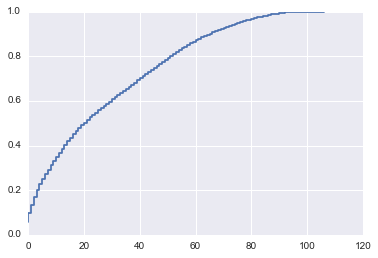

In [52]:
plt.step(range(pca.explained_variance_ratio_.shape[0]),np.cumsum(pca.explained_variance_ratio_))

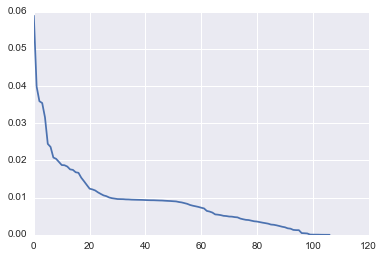

In [54]:
plt.plot(range(pca.explained_variance_ratio_.shape[0]),pca.explained_variance_ratio_)

In [5]:
np.cov(pd.DataFrame([[1,2,3,4],[2,3,4,5],[3,4,5,6]]))

array([[ 1.66666667,  1.66666667,  1.66666667],
       [ 1.66666667,  1.66666667,  1.66666667],
       [ 1.66666667,  1.66666667,  1.66666667]])

In [8]:
a = pd.DataFrame(np.array([[1,2,3,4],[2,3,4,5],[3,4,5,6]]))

In [15]:
pd.DataFrame(np.corrcoef(train_f.iloc[:,2:-2],train_f['y']))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [85]:
list(train.columns).index('technical_9')

77

In [88]:
train.ix[:,77].unique()

array([             nan,   0.00000000e+00,  -1.00000000e+00, ...,
        -9.95200455e-01,  -1.06083338e-39,  -1.77644232e-38])

(array([  9.82000000e+03,   1.21800000e+03,   7.70000000e+02,
          4.95000000e+02,   8.49000000e+02,   8.99000000e+02,
          9.31000000e+02,   1.33600000e+03,   1.20400000e+03,
          1.15000000e+03,   1.15500000e+03,   2.90000000e+01,
          1.11100000e+03,   2.60000000e+02,   1.18200000e+03,
          3.70000000e+01,   1.42500000e+03,   5.90000000e+02,
          1.65900000e+03,   1.22000000e+02,   2.70000000e+01,
          1.25000000e+03,   0.00000000e+00,   3.50000000e+01,
          4.11000000e+02,   1.09200000e+03,   6.00000000e+00,
          3.81000000e+02,   1.74200000e+03,   5.50000000e+01,
          7.00000000e+00,   2.90000000e+01,   1.30400000e+03,
          0.00000000e+00,   2.47000000e+02,   3.70000000e+01,
          9.50000000e+01,   1.91300000e+03,   2.93000000e+02,
          0.00000000e+00,   8.00000000e+00,   1.90000000e+01,
          2.78000000e+02,   1.26600000e+03,   9.00000000e+01,
          6.85000000e+02,   3.46000000e+02,   1.10000000e+01,
        

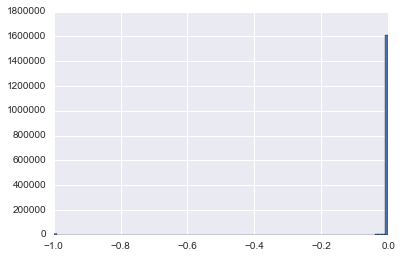

In [90]:
plt.hist(train.ix[:,77][train.ix[:,77].notnull()],bins=100)

In [162]:
rate = []
for i in train['id'].unique()[0:10]:
    temp = train.iloc[:,77][train['id']==i]
    rate.append(sum(temp[temp.notnull()])/sum(train['id']==i))
rate

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
plt.hist(rate)

In [163]:
train['id'].unique()[0:10]

array([10, 11, 12, 25, 26, 27, 31, 38, 39, 40])

(array([  1.80000000e+01,   6.00000000e+00,   4.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

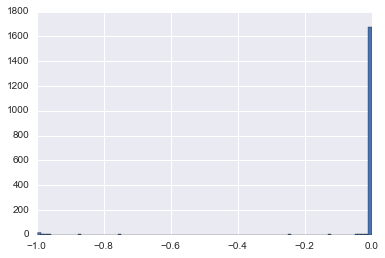

In [170]:
temp = train.iloc[:,77][train['id']==12]
cluster_data = pd.DataFrame()
for i in train['id'].unique():
    train

In [245]:
cluster_data = pd.DataFrame(index=train['timestamp'].unique())
sort_id = train['id'].unique()
sort_id.sort()

In [246]:
for i in sort_id:
    temp = train['technical_16'][train['id']==i]
    temp.index = train['timestamp'][train['id']==i]
    cluster_data[i]=temp
cluster_data

,0,6,7,10,11,12,13,14,15,16,...,2146,2148,2149,2150,2151,2152,2154,2155,2156,2158
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=0)
# km.fit(cluster_data)

In [261]:
plt.figure(figsize=(12,40))
k=0
for i in train['id'].unique():
#     k += 1
#     temp = train['technical_16'][train['id']==i]
#     plt.subplot(10,3,k)
#     plt.hist(temp[temp.notnull()], align='mid')
    temp = train['technical_34'][train['id']==i]
    if(abs(temp.mean())>0.1):
        print i, temp.mean()

93 1.0
780 -0.168110653758
1635 0.174311086535
1808 -0.599714338779
2152 0.110154412687
891 0.311766326427
1479 -0.121441394091
1866 -0.179597452283
2137 0.211984366179
7 -0.275199502707
1327 0.456642478704
1017 -0.116293206811
1324 -0.10189781338
181 0.101279638708
792 0.104214169085
1022 -0.162262767553
1062 0.103766553104
1107 -0.162577822804
1318 -0.157651811838
1541 0.110166080296
104 -0.102873779833
889 -0.164255037904
984 -0.140688449144
791 -0.157395154238
1290 0.123328879476
1357 -0.238717138767
1442 -0.132441699505
357 -0.262595325708
382 -0.15313924849
462 0.11274214834
760 -0.10564097017
1010 -0.101915806532
1243 -0.207808166742
1311 0.10564097017
1354 -0.11274214834
663 0.229494735599
1427 0.135915800929
1614 0.135915800929
1265 1.0


In [5]:
tot_col = [i for i in train.columns.unique() if i not in ['y','timestamp','id']]
cormat = pd.DataFrame()
ids = train['id'].unique()
for id in ids:
    temp = train[train['id']==id]
    cormat[id] = temp.drop(['y','timestamp','id'],axis=1).corrwith(temp['y'])
cormat

/Users/wenhaohu/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2079: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


,10,11,12,25,26,27,31,38,39,40,...,861,882,1320,1506,1726,1809,2063,2076,435,1229
derived_0,-0.141356,0.004363,0.013156,-0.017381,-0.038954,0.015425,-0.049455,-0.011881,0.022028,-0.006472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
derived_1,0.117364,-0.015384,-0.027269,-0.012106,-0.012848,-0.059563,0.041687,0.001637,0.008188,-0.008629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
derived_2,0.008877,-0.010113,0.024922,0.001815,0.003076,-0.070924,NaN,0.007301,0.007242,-0.007721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
derived_3,0.058231,-0.012139,-0.030383,0.015066,-0.032857,0.034859,-0.059478,-0.025262,0.009551,-0.027504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
derived_4,-0.133042,0.008590,0.011176,-0.009798,-0.019466,-0.033293,NaN,-0.020513,0.001771,0.003168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fundamental_0,0.150588,-0.025903,-0.009791,-0.018309,-0.012961,-0.014074,-0.003015,-0.009911,-0.012134,0.008431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fundamental_1,-0.208204,-0.018293,-0.003788,-0.005735,-0.004767,NaN,NaN,-0.030781,0.000882,-0.005743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fundamental_2,-0.052999,0.019532,-0.008545,0.036445,0.003848,-0.008763,NaN,0.015759,0.006500,-0.012187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fundamental_3,-0.200984,0.012689,-0.008295,-0.003348,0.000128,NaN,NaN,-0.018769,0.004075,-0.066018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fundamental_5,NaN,-0.013051,NaN,NaN,NaN,NaN,NaN,0.005544,NaN,0.004306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


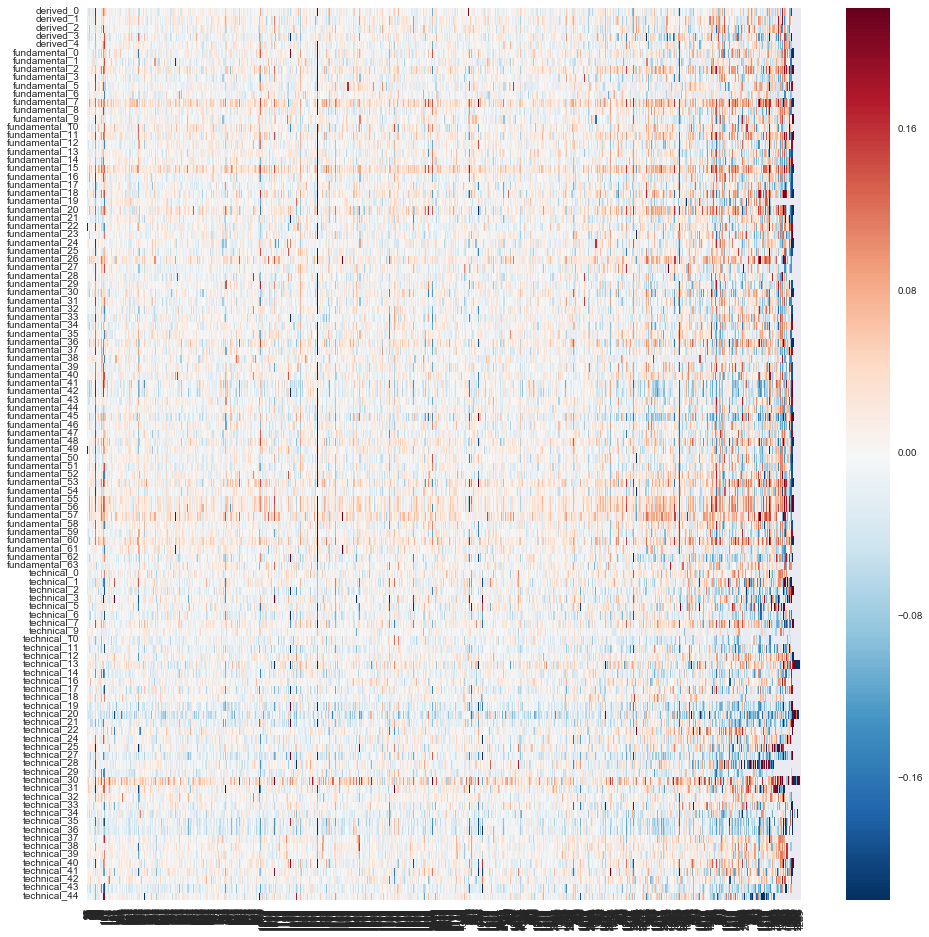

In [366]:
plt.figure(figsize=(16,16))
sns.heatmap(cormat, vmin=-0.22,vmax=0.22)

In [2]:
positive_cor=['fundamental_7','fundamental_15','fundamental_26',
              'fundamental_53','fundamental_55',
              'fundamental_56','fundamental_57','fundamental_60',
              'technical_30','fundamental_11']
negative_cor=['fundamental_7','fundamental_15','fundamental_26',
              'fundamental_53','fundamental_55','fundamental_56',
              'fundamental_57', 'fundamental_60','technical_19',
              'technical_20']

In [3]:
pos_neg = [i for i in positive_cor if i in negative_cor]

In [6]:
cormat_imput = pd.DataFrame()
for i in ids:
    temp = train_f[train_f['id']==i]
    cormat_imput[i] = temp[pos_neg].corrwith(temp['y'])

10
11
12
25
26
27
31
38
39
40
41
43
44
49
54
59
60
62
63
68
69
70
76
79
80
82
83
85
87
90
91
93
95
98
102
103
105
111
112
113
118
119
121
124
126
128
129
130
132
140
141
142
152
154
156
160
169
171
172
175
176
178
184
186
187
191
195
198
199
203
206
214
215
216
217
219
223
224
225
229
231
232
235
239
240
241
242
244
248
249
252
255
257
259
261
262
264
265
266
268
269
270
273
280
281
284
285
286
287
288
289
290
296
297
300
302
306
317
318
319
338
341
343
344
347
348
349
351
352
358
362
365
372
377
383
388
391
395
396
402
406
407
408
413
417
419
425
430
431
433
438
441
445
451
452
453
456
467
468
473
474
479
480
481
484
490
492
500
501
502
505
506
507
509
510
512
513
520
523
527
529
530
531
532
535
536
540
542
543
545
548
550
551
556
557
558
559
565
567
568
571
577
578
579
580
583
584
586
587
588
591
593
594
600
602
605
608
611
615
617
618
619
620
624
625
631
633
636
637
638
639
646
650
651
654
656
657
667
669
670
677
679
682
684
686
689
690
691
694
695
696
697
698
699
703
704
707
709
71

In [20]:
cormat_imput.T

,fundamental_7,fundamental_15,fundamental_26,fundamental_53,fundamental_55,fundamental_56,fundamental_57,fundamental_60
10,0.161906,0.169187,0.165552,0.169649,-0.113058,-0.017800,0.165552,-0.123347
11,0.037314,0.031079,0.033888,0.036508,0.020804,0.020564,0.024231,0.027956
12,0.020120,0.034477,0.032756,0.030094,-0.006783,-0.002509,0.033599,0.003276
25,0.059405,0.047929,-0.008759,0.049303,0.043140,0.040213,-0.007303,0.046824
26,-0.001823,0.006042,-0.009420,0.000088,0.002604,0.005723,0.000886,-0.030307
27,0.066692,0.070449,0.067075,0.073000,0.092077,0.092021,0.067075,0.078522
31,0.093704,NaN,NaN,-0.005138,NaN,NaN,NaN,NaN
38,0.023463,0.027794,0.031894,0.005545,0.013485,0.021537,0.021541,0.012506
39,0.034940,0.028317,0.028905,0.032544,0.007550,0.008615,0.023763,0.014301
40,0.001906,0.005812,0.014319,-0.010363,-0.011684,-0.012383,0.014452,0.013244


In [9]:
from sklearn.metrics import silhouette_score
scores = []
for i in range(2,10):
    km.fit(cormat.T[pos_neg])
    print(silhouette_score(cormat.T[pos_neg],km.labels_))
plt.plot(range(2,10), scores)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

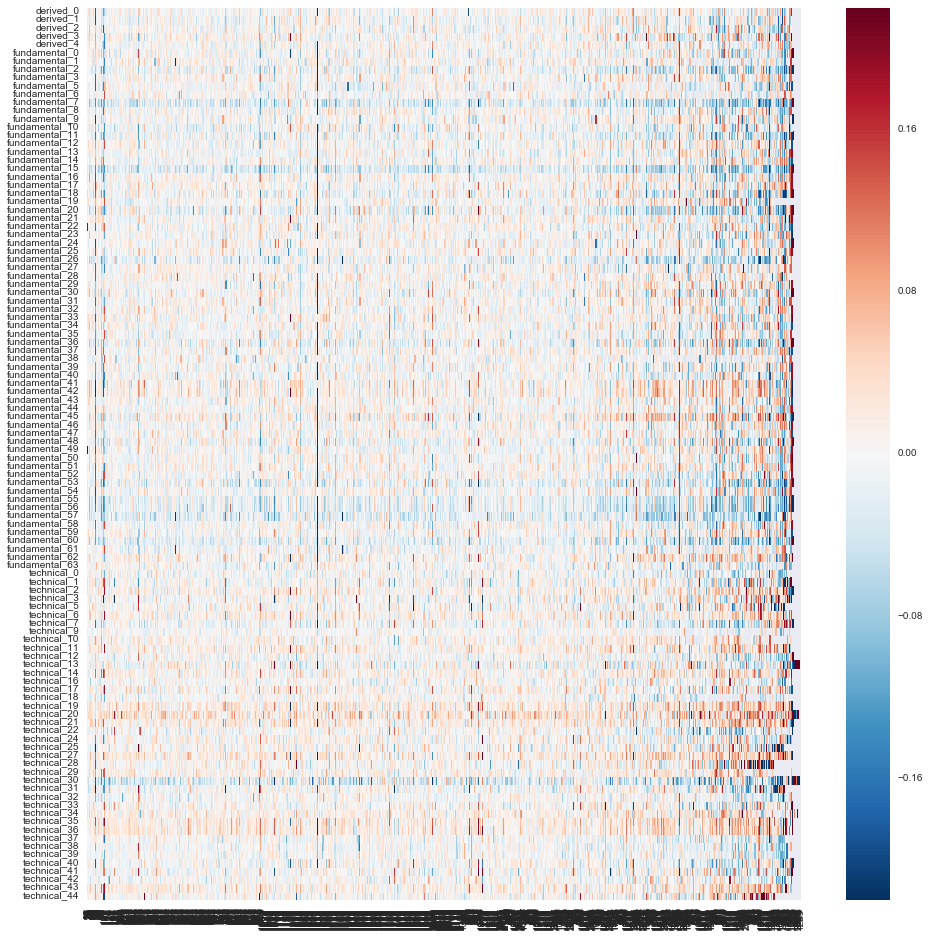

In [365]:
plt.figure(figsize=(16,16))
sns.heatmap(-cormat, vmin=-0.22,vmax=0.22)

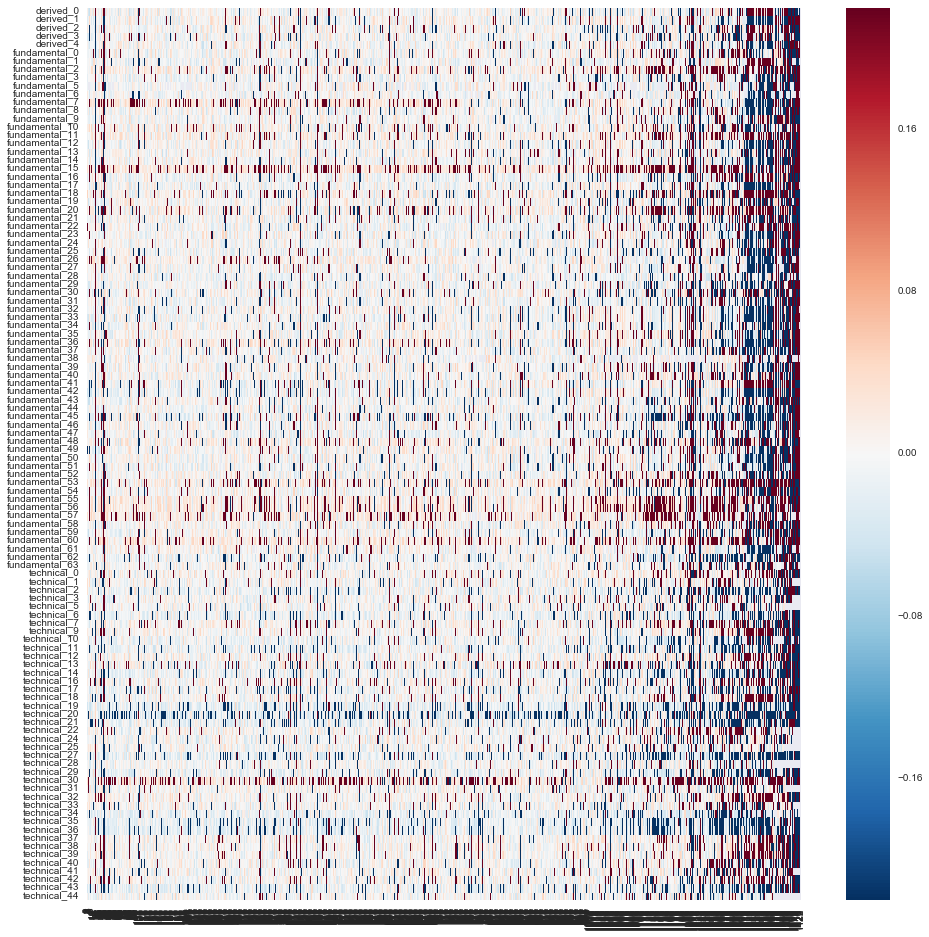

In [355]:
plt.figure(figsize=(16,16))
sns.heatmap(test, vmin=-0.22,vmax=0.22)